In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

In [2]:
# Load dataset
df = pd.read_csv('./dataset/Thyroid_Diff.csv')

## 1. Exploratory Data Analysis (EDA)

In [3]:
# 1.1 Basic Data Exploration
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

1. EXPLORATORY DATA ANALYSIS

Dataset Shape: (383, 17)

First 5 rows:


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No



Data Types:
Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

Missing Values:
Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred     


Target Variable Distribution:
Recurred
No     0.718016
Yes    0.281984
Name: proportion, dtype: float64


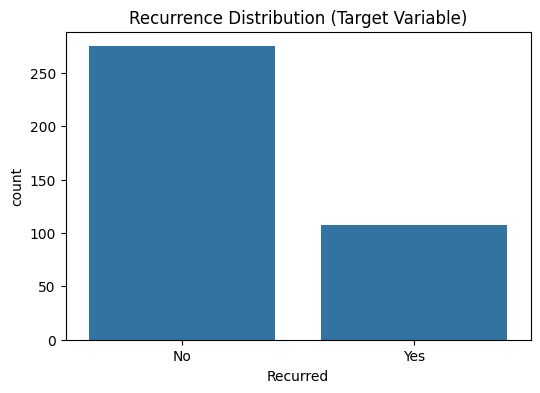

In [4]:
# 1.2 Target Variable Analysis
print("\nTarget Variable Distribution:")
print(df['Recurred'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Recurred')
plt.title('Recurrence Distribution (Target Variable)')
plt.show()

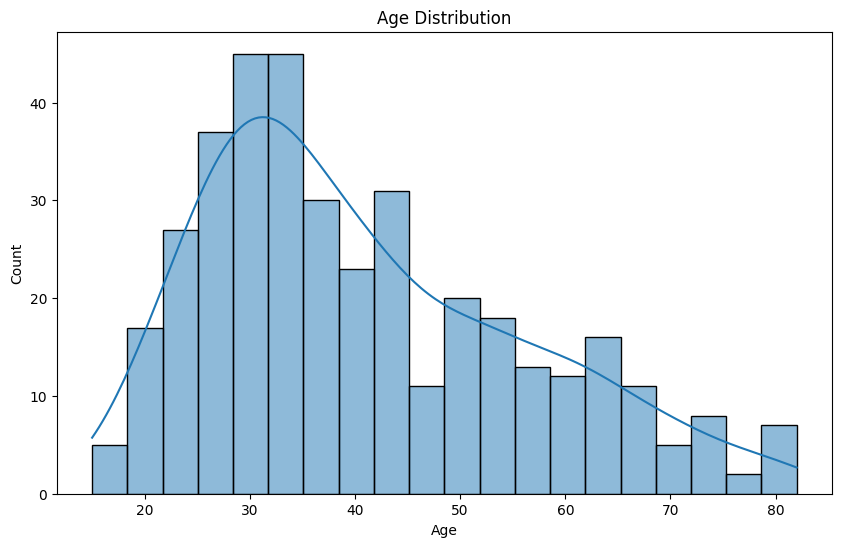

In [5]:
# 1.3 Numerical Feature Analysis
numerical_cols = ['Age']
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

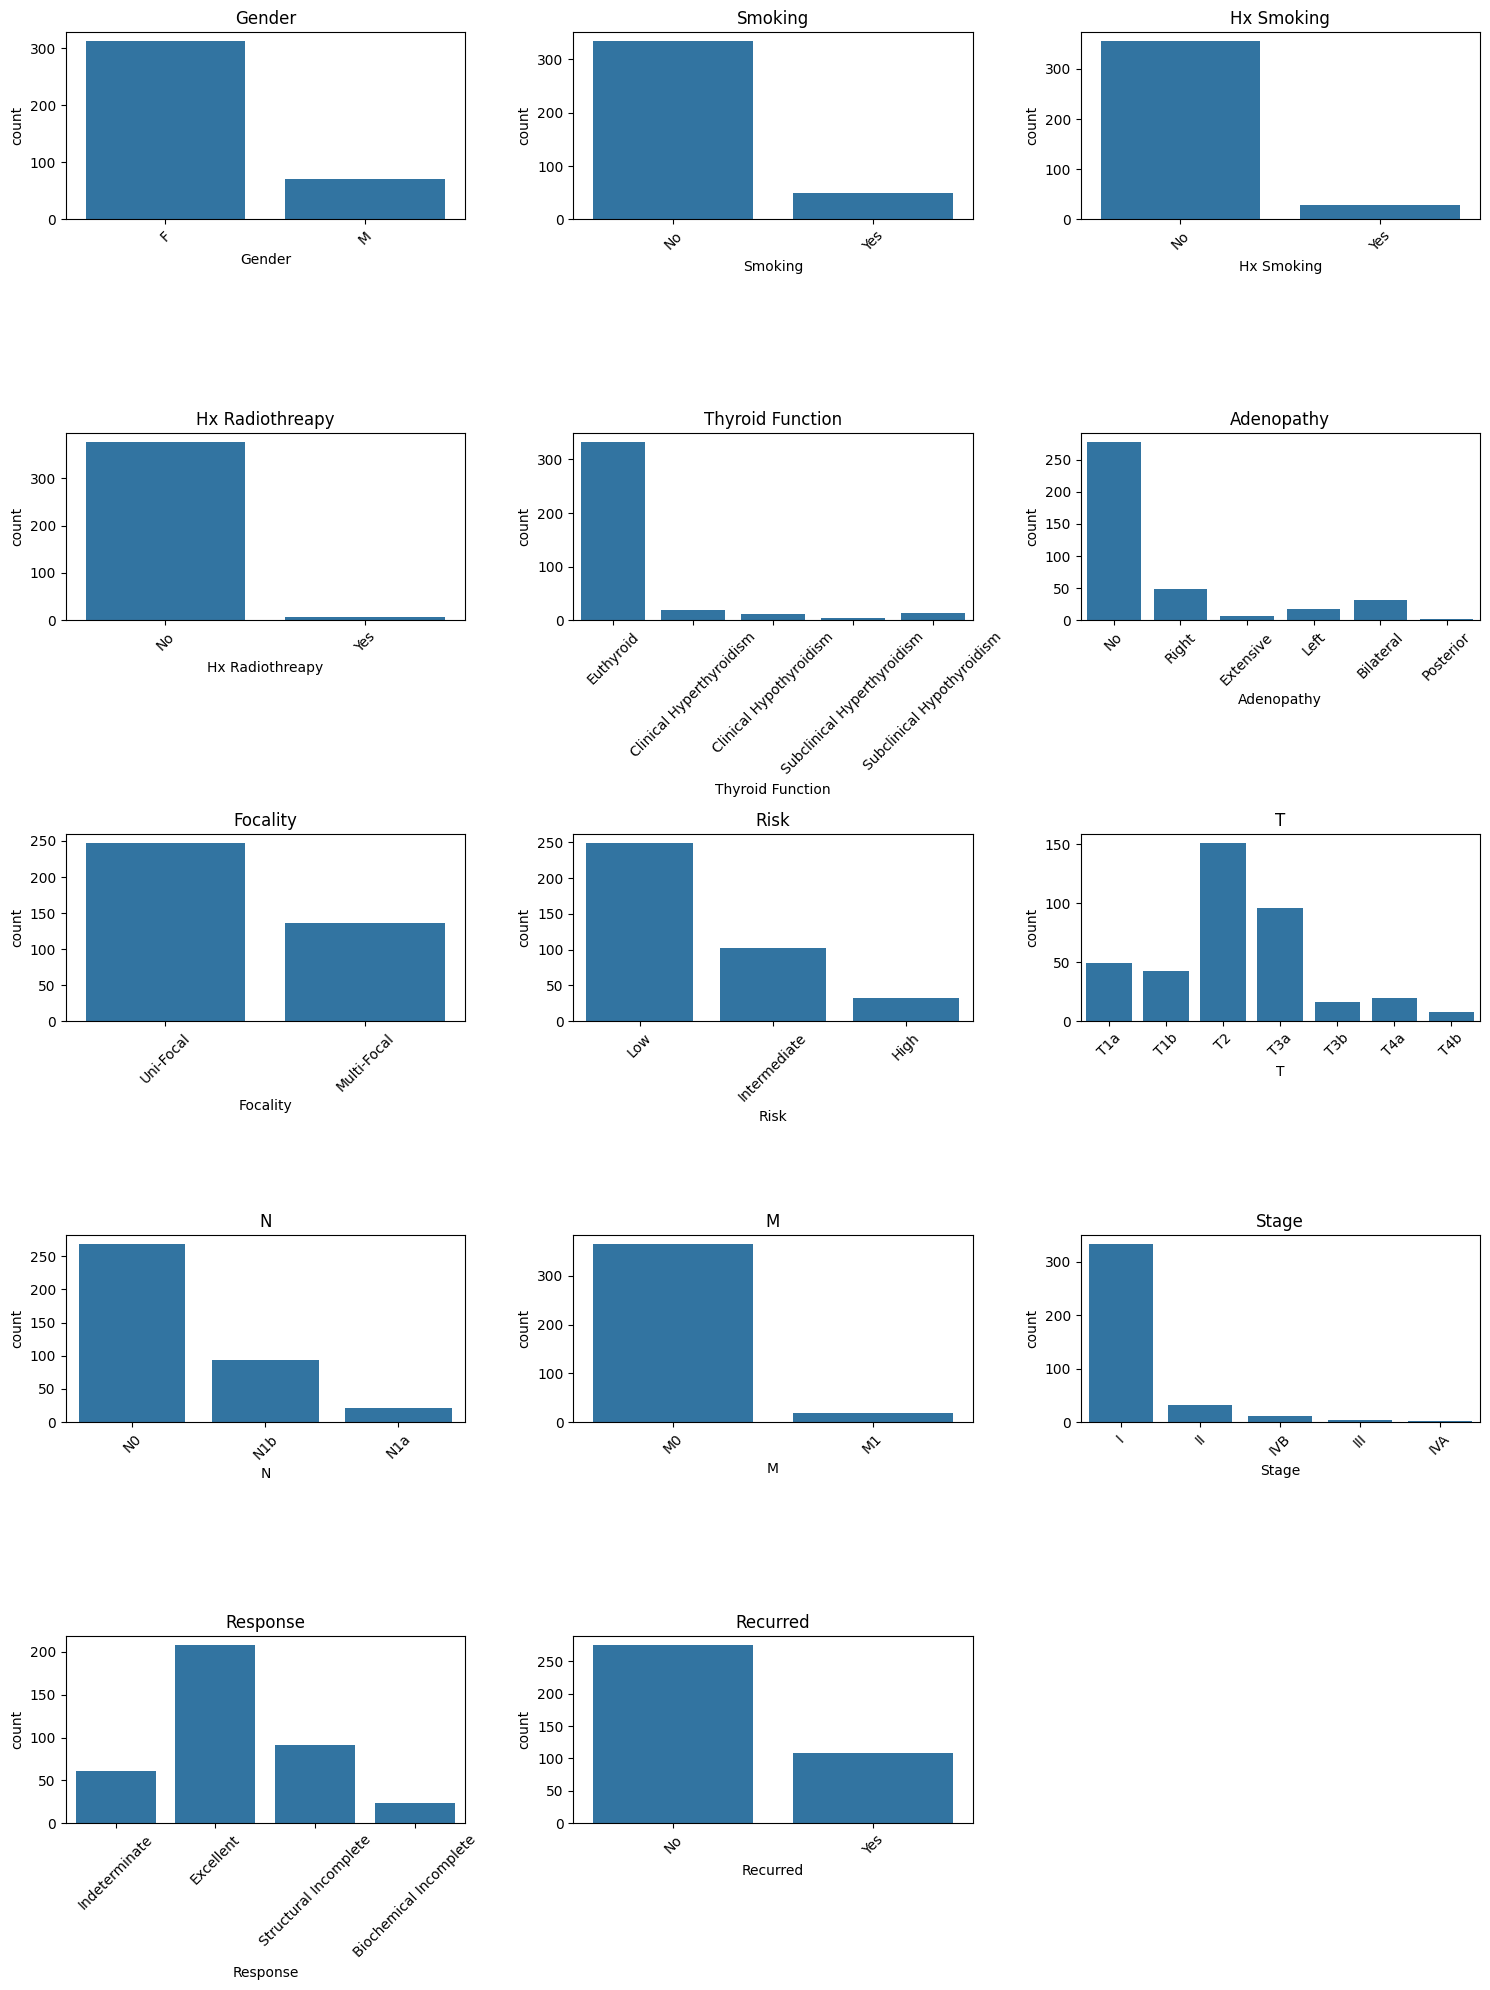

In [6]:
# 1.4 Categorical Feature Analysis
categorical_columns = ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
                     'Thyroid Function', 'Adenopathy', 'Focality', 'Risk',
                     'T', 'N', 'M', 'Stage', 'Response', 'Recurred']

plt.figure(figsize=(15,20))
for i, col in enumerate(categorical_columns):
    plt.subplot(5, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

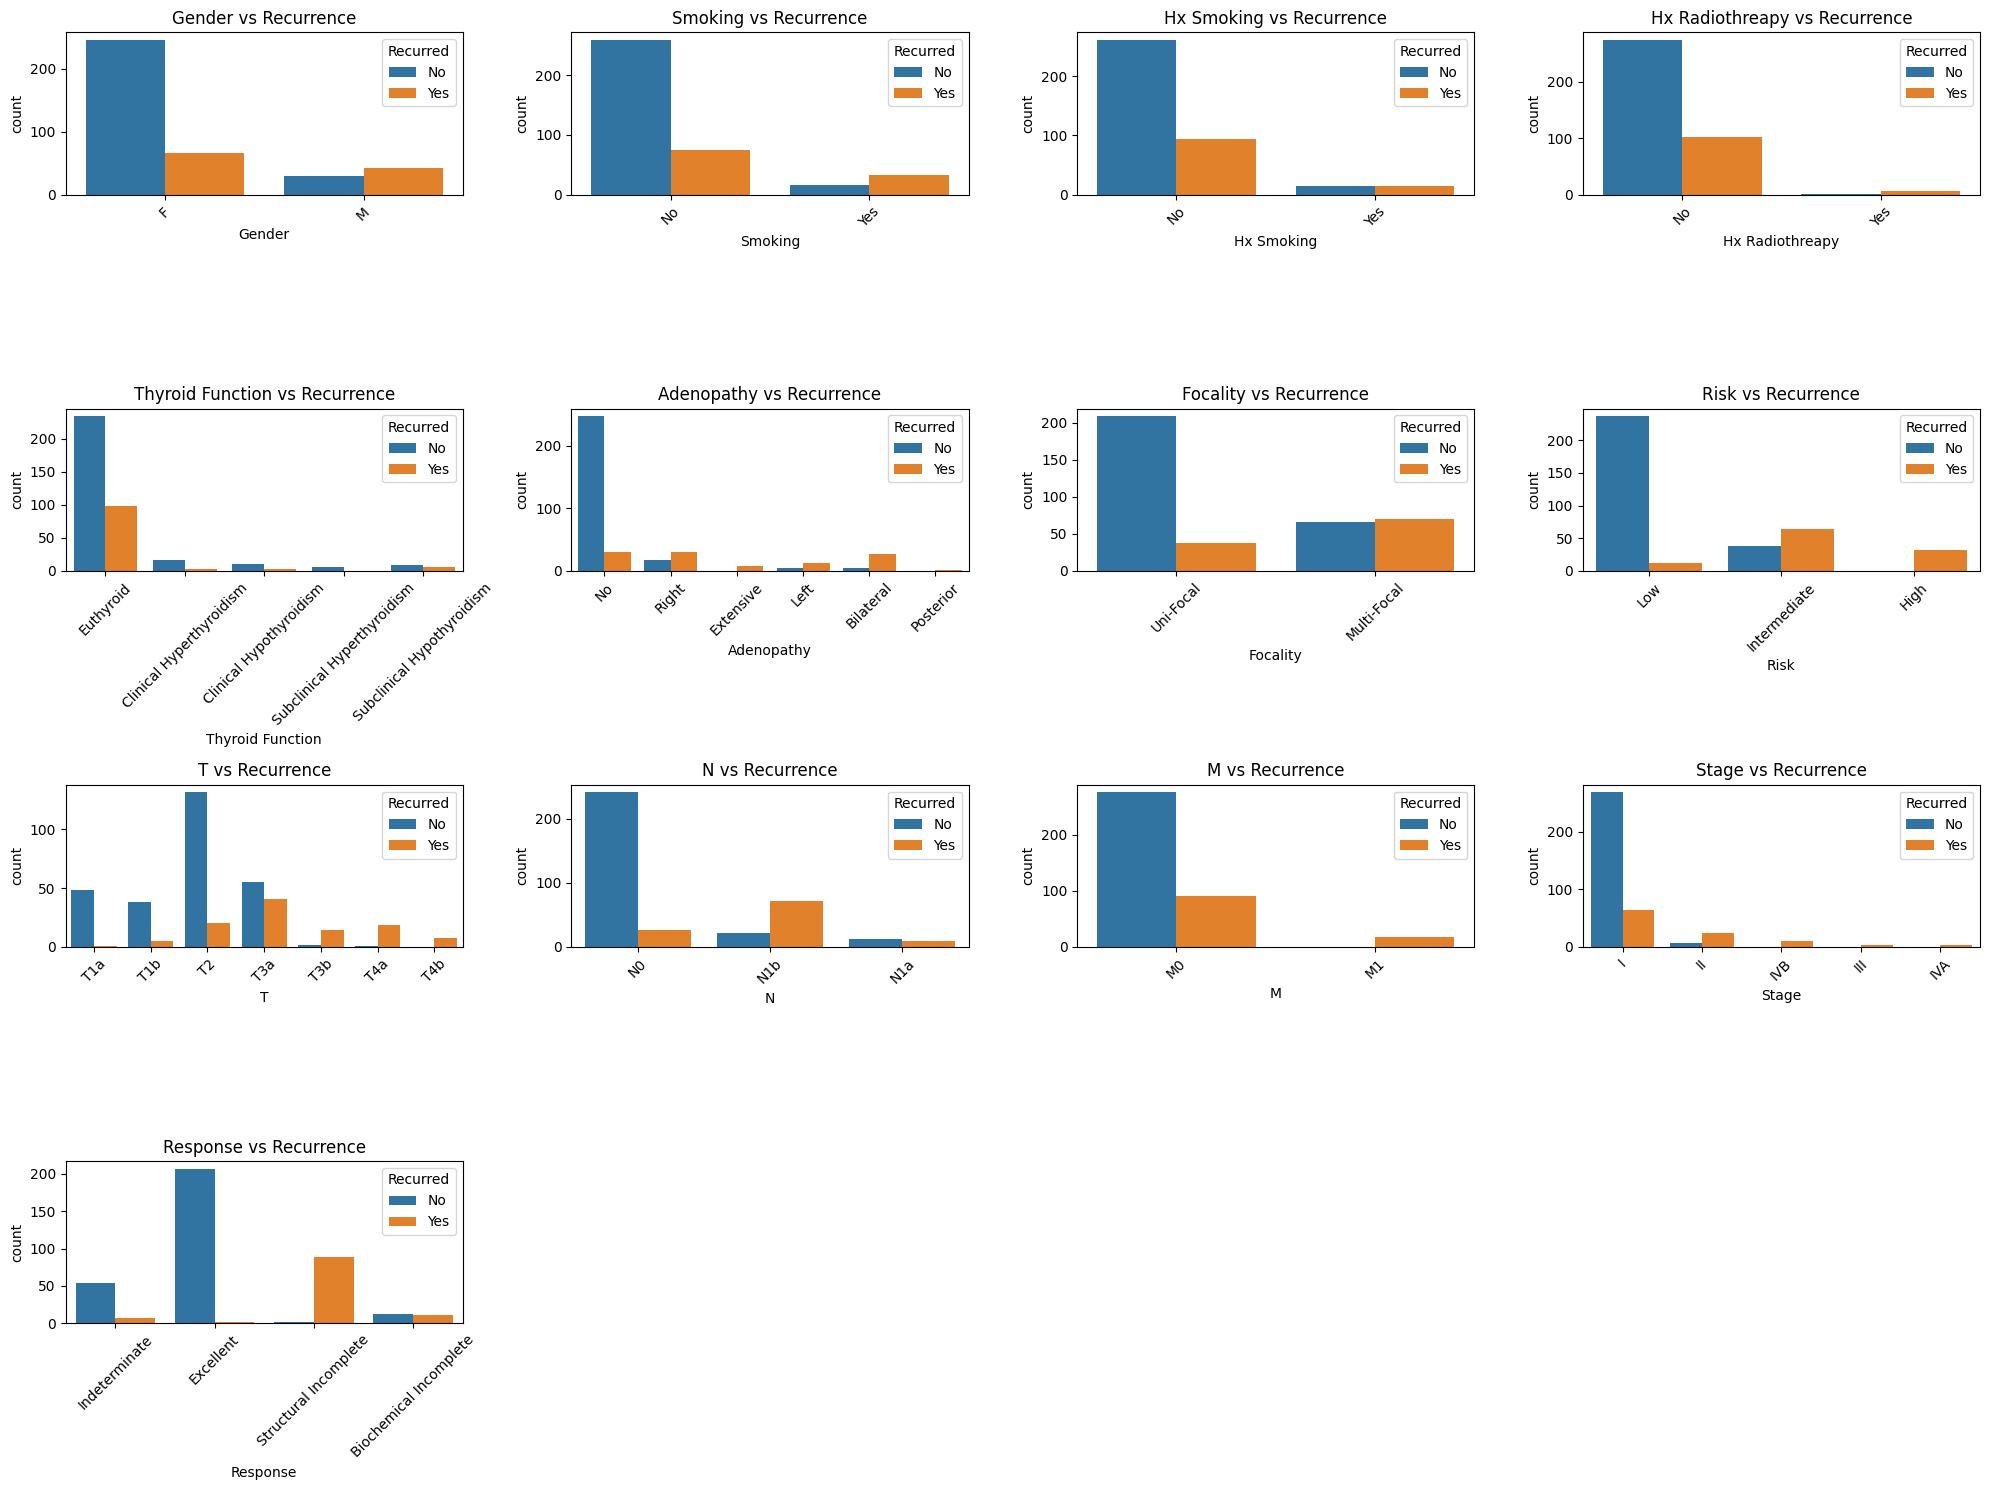

In [7]:
# 1.5 Feature-Target Relationships
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_columns[:-1]):  # Exclude 'Recurred'
    plt.subplot(4, 4, i+1)
    sns.countplot(data=df, x=col, hue='Recurred')
    plt.title(f'{col} vs Recurrence')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

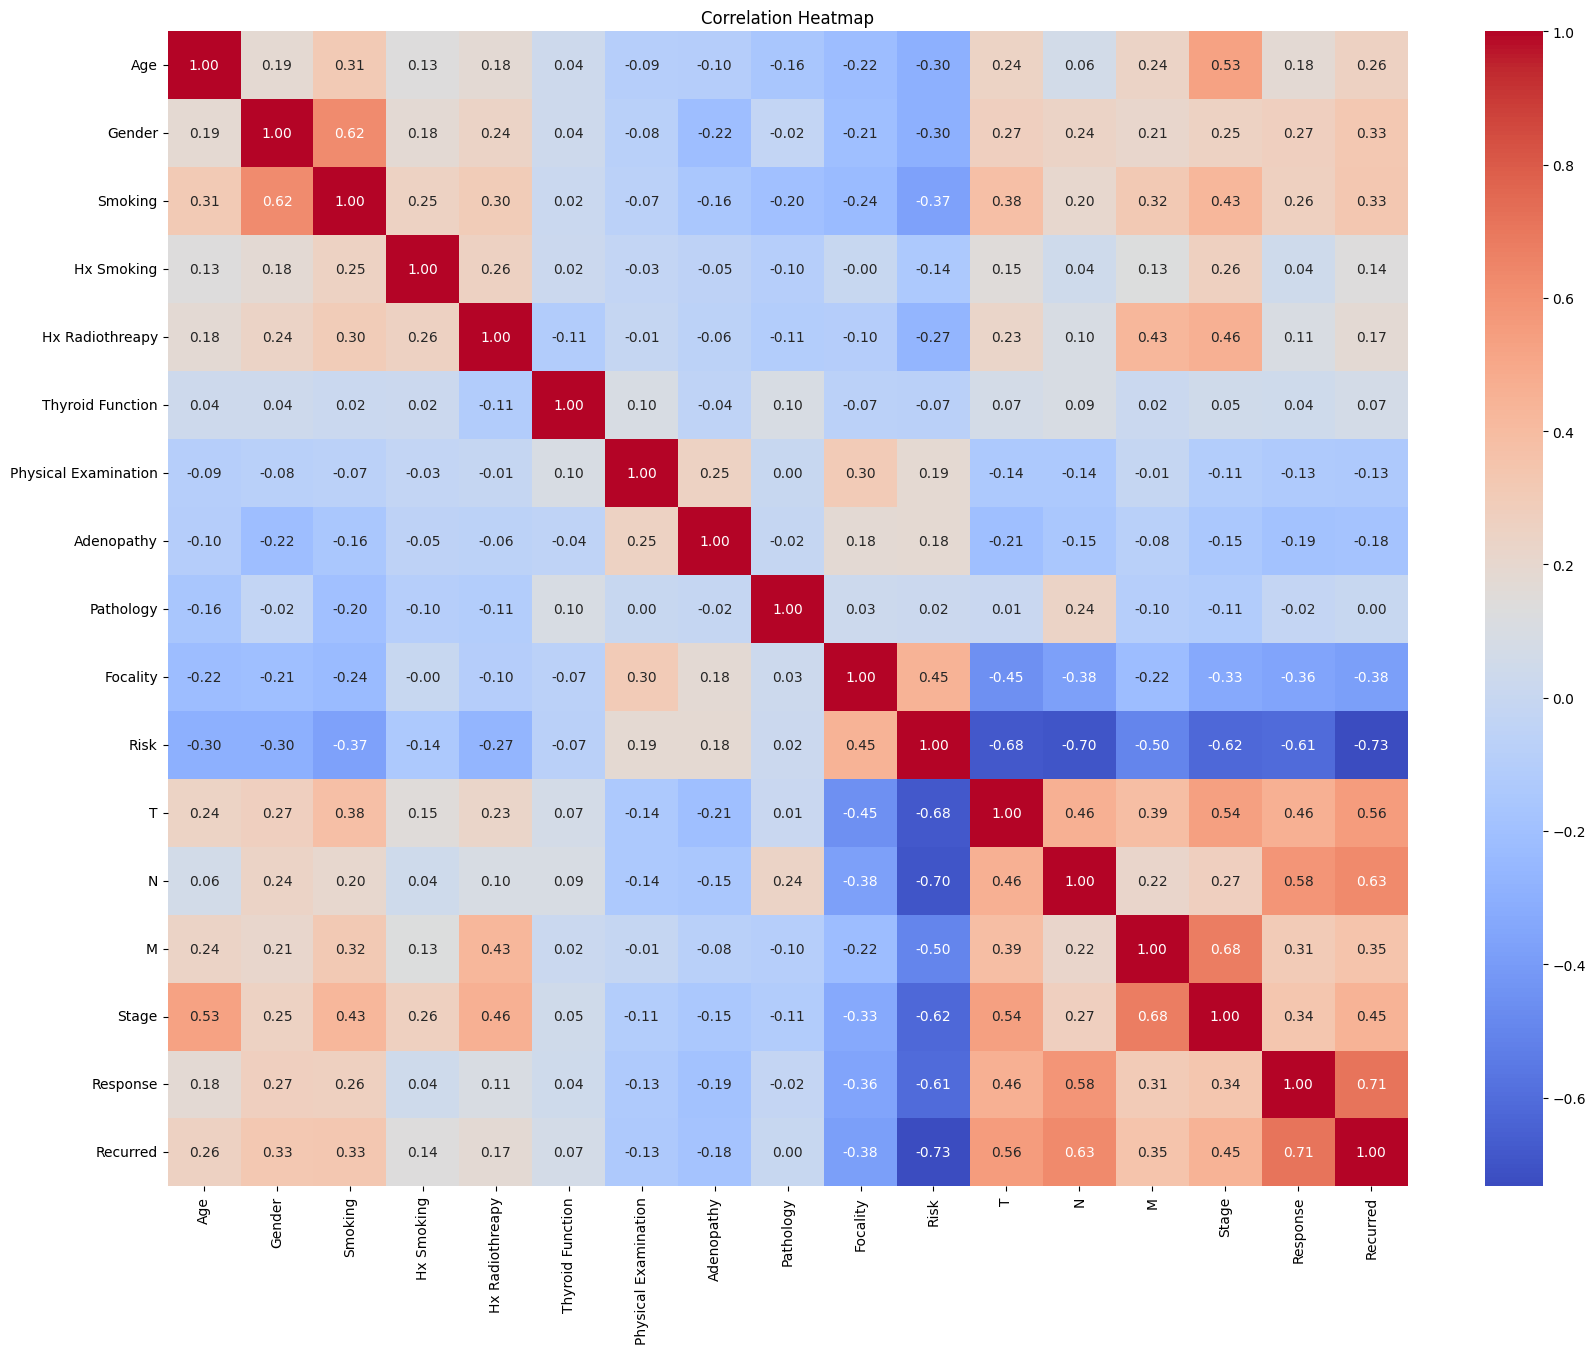

In [8]:
# 1.6 Correlation Analysis
df_encoded = df.copy()
for col in categorical_columns + ['Physical Examination', 'Pathology']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

plt.figure(figsize=(20, 15))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

## 2. Feature Engineering

In [9]:
# 2.1 Data Preprocessing
# Handle missing values if any
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_256144/3301693532.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [10]:
# Encode categorical variables
label_encoders = {}
for col in categorical_columns[:-1]:  # Exclude target variable
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [11]:
# Encode target variable
target_encoder = LabelEncoder()
df['Recurred'] = target_encoder.fit_transform(df['Recurred'])

In [12]:
# 2.2 Feature-Target Separation
X = df.drop('Recurred', axis=1)
y = df['Recurred']

In [13]:
# 2.3 Feature Scaling

# identify which columns are numerical and which are categorical/text
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", numerical_cols)
print("Categorical/text columns:", categorical_cols)

if len(categorical_cols) > 0:
    print("\nEncoding categorical/text columns...")
    from sklearn.preprocessing import OneHotEncoder
    
    # One-hot encode categorical columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(X[categorical_cols])
    
    # Create column names for the encoded features
    encoded_cols = []
    for i, col in enumerate(categorical_cols):
        for cat in encoder.categories_[i]:
            encoded_cols.append(f"{col}_{cat}")
    
    # Create DataFrame from encoded features
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cols)
    
    # Combine numerical and encoded categorical features
    X_processed = pd.concat([X[numerical_cols].reset_index(drop=True), 
                           encoded_df.reset_index(drop=True)], axis=1)
else:
    X_processed = X.copy()

# apply StandardScaler only to numerical columns
scaler = StandardScaler()
X_scaled = X_processed.copy()  # Keep original for non-scaled columns

# Scale only numerical columns 
if len(numerical_cols) > 0:
    X_scaled[numerical_cols] = scaler.fit_transform(X_processed[numerical_cols])

print("\nAfter preprocessing:")
print(X_scaled.head())

Numerical columns: Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Adenopathy', 'Focality', 'Risk', 'T', 'N', 'M',
       'Stage', 'Response'],
      dtype='object')
Categorical/text columns: Index(['Physical Examination', 'Pathology'], dtype='object')

Encoding categorical/text columns...

After preprocessing:
        Age    Gender   Smoking  Hx Smoking  Hx Radiothreapy  \
0 -0.917439 -0.477037 -0.383023   -0.280844        -0.136444   
1 -0.454315 -0.477037 -0.383023    3.560698        -0.136444   
2 -0.718957 -0.477037 -0.383023   -0.280844        -0.136444   
3  1.398184 -0.477037 -0.383023   -0.280844        -0.136444   
4  1.398184 -0.477037 -0.383023   -0.280844        -0.136444   

   Thyroid Function  Adenopathy  Focality      Risk       T  ...  Response  \
0          0.078732    0.064684  0.742029  0.674696 -1.6429  ...  0.464420   
1          0.078732    0.064684  0.742029  0.674696 -1.6429  ... -0.626824   
2          0.078732 

In [16]:
# 2.4 Feature Selection

# a. Ensure we're using the processed data (numerical + encoded categoricals)
X_processed = X_scaled.copy()

# b. Feature selection setup
# Choose k - either fixed number or percentage
k_features = min(10, X_processed.shape[1])  # Don't exceed available features
selector = SelectKBest(score_func=f_classif, k=k_features)

# c. Fit selector to processed data
X_selected = selector.fit_transform(X_processed, y)

# d. Get selected feature names
# Get all column names in the processed data
processed_columns = list(numerical_cols) + encoded_cols

# e.Get the selection mask and apply to our column names
selected_mask = selector.get_support()
selected_features = [processed_columns[i] 
                    for i in range(len(selected_mask)) 
                    if selected_mask[i]]

print(f"\nSelected {len(selected_features)} features:")
print(selected_features)


Selected 10 features:
['Age', 'Gender', 'Smoking', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']



All features ranked by ANOVA F-score:


,Feature,Score,P-value
8,Risk,443.390121,7.723436e-66
13,Response,385.013106,9.520716e-60
10,N,253.823287,3.710287e-44
9,T,170.661941,1.741654e-32
12,Stage,96.278731,2.063300e-20
7,Focality,65.807733,6.902362e-15
11,M,54.712794,8.968689e-13
2,Smoking,47.595845,2.192081e-11
1,Gender,45.990326,4.546791e-11
0,Age,27.372236,2.776541e-07


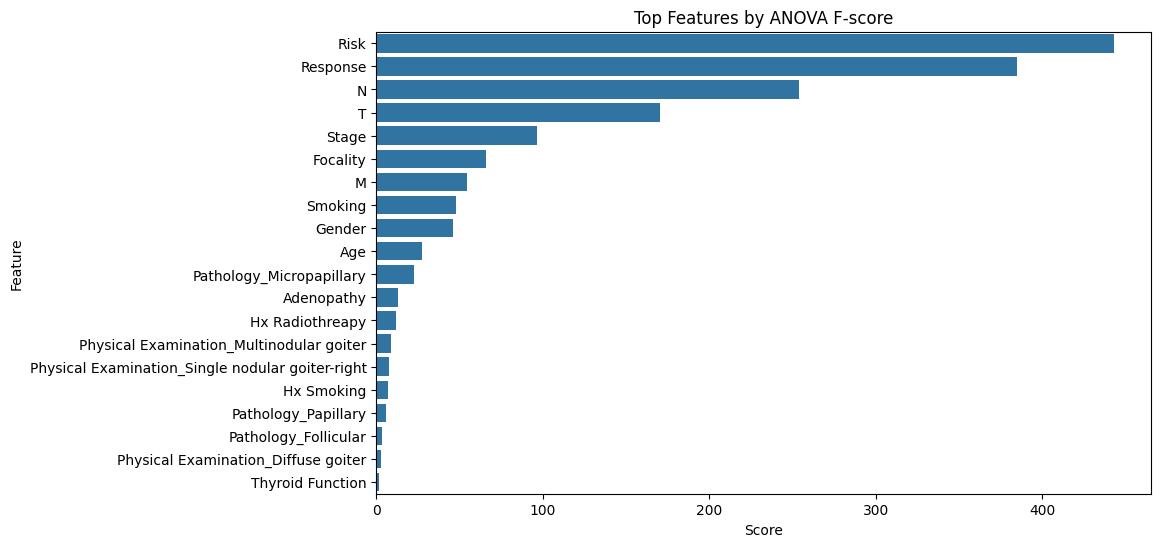

In [17]:
# Create a DataFrame of feature scores
feature_scores = pd.DataFrame({
    'Feature': processed_columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
}).sort_values('Score', ascending=False)

print("\nAll features ranked by ANOVA F-score:")
display(feature_scores)

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(data=feature_scores.head(20), x='Score', y='Feature')
plt.title('Top Features by ANOVA F-score')
plt.show()

In [18]:
# Update X with selected features
X = X[selected_features]
X_scaled = X_scaled[selected_features]


In [19]:
# 2.5 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, 
                                                   random_state=42, stratify=y)

In [20]:
# 2.6 Handle Class Imbalance with SMOTE
print("\nClass distribution before SMOTE:")
print(pd.Series(y_train).value_counts())


Class distribution before SMOTE:
Recurred
0    192
1     76
Name: count, dtype: int64


In [21]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
Recurred
1    192
0    192
Name: count, dtype: int64


## 3. Model Training

In [22]:
# 3.1 Initialize Base Models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)

In [23]:
# 3.2 Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [24]:
rf_grid = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_

In [25]:
print("\nRandom Forest Best Parameters:", rf_grid.best_params_)


Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [26]:
# 3.3 Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    voting='soft'  # For probability estimates
)

In [27]:
# 3.4 Train Hybrid Model
voting_clf.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 192, number of negative: 192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm', LGBMClassifier(random_state=42))],
                 voting='soft')


Hybrid Model Evaluation:
Accuracy: 0.9478
ROC AUC Score: 0.9944

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        83
           1       0.88      0.94      0.91        32

    accuracy                           0.95       115
   macro avg       0.93      0.94      0.94       115
weighted avg       0.95      0.95      0.95       115



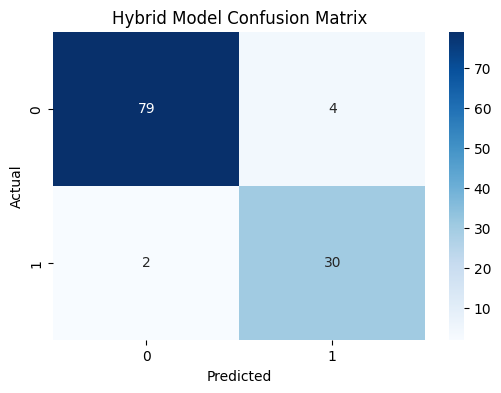

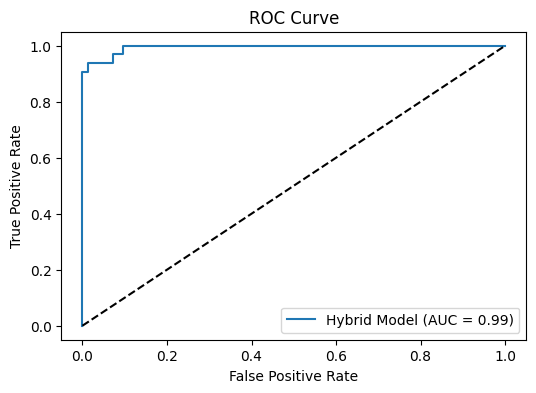

In [30]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return accuracy, roc_auc

# Evaluation
hybrid_acc, hybrid_auc = evaluate_model(voting_clf, X_test, y_test, "Hybrid Model")
